# Analyse Results for Transfer Learning tests
- European data
- Each model trained on 200 samples
- Ensemble size is 20
- 20 Ensembles
- Compare full transfer and frozen layers with no transfer learning

## Imports

In [1]:
import glob
import json
import os
import pandas as pd
import random

from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

import initialise
import common
from results_utils import generate_ensembles
from analysis_utils import calc_statistics, sort_file_list
from display_utils import display_frames

In [2]:
SMALL_SIZE = 7
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('legend', title_fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
legend_title = 'Training Data\nSample Set Size'

## Directories and other settings
- Update the model directories as required

In [4]:
results_dir = os.path.join(common.DATA_DIR, 'Results')
output_dir = common.FIGURES_DIR
precision = 3       # floating point precision for saved predictions

In [5]:
def get_test_results(size, test):
    results_temp = []
    stats_file = os.path.join(results_dir, f"Europe{size}", f"{test}_stats.csv")
    return pd.read_csv(stats_file, index_col=1)

In [6]:
sizes = ['200', '500', '1000', 'Full', 'none']
tests = ['Source-only',
         'AdaBN',
         'Target-only',
         'Sourcerer-reg',
         'Naive',
         'Freeze-1st',
         'Freeze-BN',
         'Sourcerer']

results_dict = {s: {} for s in sizes}
for s in sizes:
    if s == 'none':
        results_dict[s]['Source-only'] = get_test_results('Full', 'Source-only')
    else:
        for e, t in enumerate(tests):
            if e > 0:
                t1 = 'Naive\nfine-tuning' if t == 'Naive' else t
                results_dict[s][t1] = get_test_results(s, t)

In [7]:
rmse_results = []
rmse_keys = []
for s in sizes:
    if len(results_dict[s]) > 0:
        rmse_results.append(pd.concat([results_dict[s][t]['RMSE'] for t in results_dict[s].keys()],
                                      axis=1, keys=results_dict[s].keys(), names=['Test Name']).T)
        rmse_keys.append(s)
rmse_results = pd.concat(rmse_results, keys=rmse_keys, names=[legend_title]).stack().reset_index()
rmse_summ = rmse_results.groupby([legend_title, 'Test Name'])[0].mean().unstack(level=0)[rmse_keys]

In [8]:
r2_results = []
r2_keys = []
for s in sizes:
    if len(results_dict[s]) > 0:
        r2_results.append(pd.concat([results_dict[s][t]['R2'] for t in results_dict[s].keys()],
                                    axis=1, keys=results_dict[s].keys(), names=['Test Name']).T)
        r2_keys.append(s)
r2_results = pd.concat(r2_results, keys=r2_keys, names=[legend_title]).stack().reset_index()
r2_summ = r2_results.groupby([legend_title, 'Test Name'])[0].mean().unstack(level=0)[r2_keys]

## Figures

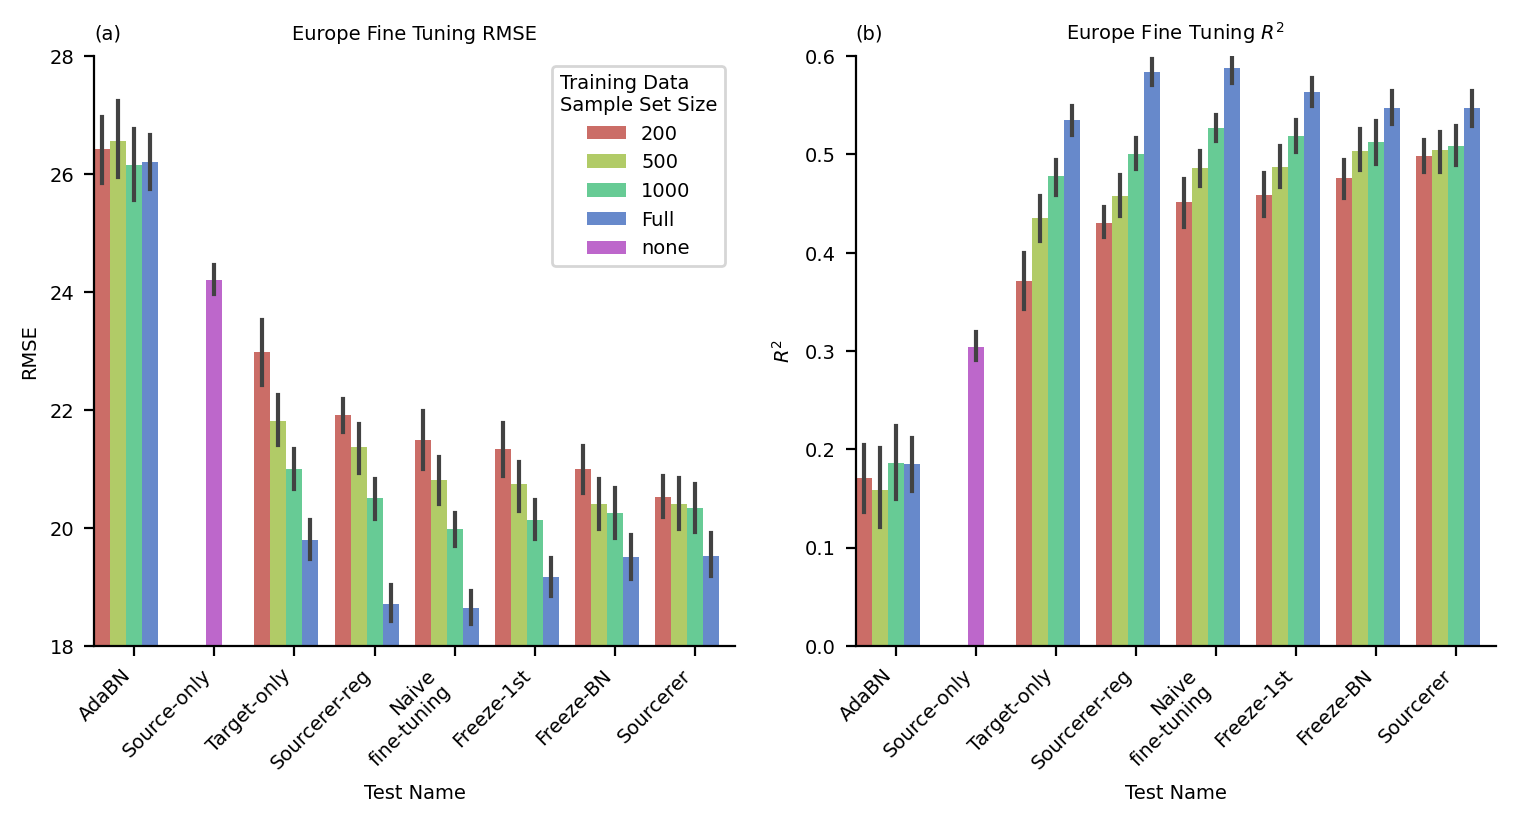

In [9]:
source_only_pos = 33
sns.set_palette("hls", 5)

fig1, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.464, 4.0), dpi=200, layout='constrained',
                          gridspec_kw={'wspace': 0.05, 'hspace': 0.05})
plot_order = rmse_summ.max(axis=1).sort_values(ascending=False).index.values

ax = axes[0]
ax = sns.barplot(data=rmse_results, y=0, x='Test Name', hue=legend_title, ax=ax, order=plot_order, errwidth=1.5, width=1.0)
ax.set_ylabel('RMSE')
ax.set_ylim(18, 28)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Europe Fine Tuning RMSE')
ax.set_title('(a)', loc='left')
for axis in ['top', 'right']:
    ax.spines[axis].set_visible(False)
bar_ = axes[0].findobj(Rectangle)[source_only_pos]
bar_.set_x(np.floor(bar_.get_x())-bar_.get_width()/2)
line_ = axes[0].findobj(Line2D)[source_only_pos]
xpos = line_.get_xdata((1, 1))
line_.set_xdata((np.floor(xpos[0]), np.floor(xpos[1])))
    
ax = axes[1]
ax = sns.barplot(data=r2_results, y=0, x='Test Name', hue=legend_title, ax=ax, order=plot_order, errwidth=1.5, width=1.0)
ax.set_ylabel('$R^2$')
ax.set_ylim(0.0, 0.6)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Europe Fine Tuning $R^2$')
ax.set_title('(b)', loc='left')
ax.legend().remove()
for axis in ['top', 'right']:
    ax.spines[axis].set_visible(False)
bar_ = axes[1].findobj(Rectangle)[source_only_pos]
bar_.set_x(np.floor(bar_.get_x())-bar_.get_width()/2)
line_ = axes[1].findobj(Line2D)[source_only_pos]
xpos = line_.get_xdata((1, 1))
line_.set_xdata((np.floor(xpos[1]), np.floor(xpos[1])))

#fig1.savefig(os.path.join(output_dir, 'Europe results.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.05, dpi=500)

In [10]:
rmse_summ = rmse_summ.sort_values('200', ascending=False)
r2_summ = r2_summ.sort_values('200')
display_frames([rmse_summ, r2_summ], ['$RMSE$', '$R^2$'], precision=2)

Training Data Sample Set Size,200,500,1000,Full,none
Test Name,,,,,
AdaBN,26.42,26.56,26.16,26.20,nan
Target-only,22.98,21.81,20.99,19.79,nan
Sourcerer-reg,21.91,21.36,20.51,18.72,nan
Naive fine-tuning,21.49,20.81,19.98,18.64,nan
Freeze-1st,21.34,20.74,20.13,19.16,nan
Freeze-BN,21.01,20.41,20.25,19.50,nan
Sourcerer,20.53,20.41,20.34,19.53,nan
Source-only,nan,nan,nan,nan,24.21
Training Data Sample Set Size,200,500,1000,Full,none
